In [82]:
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
# Loading in our news data and robinhood data
# PLEASE MAKE SURE YOUR HEADLINES AND SENTIMENT CSV IS THE MOST RECENT VERSION
news_data = pd.read_csv('headlines_and_sentiment.csv')
robinhood_data = pd.read_csv('closing_popularity.csv')

In [3]:
news_data['date'] = [datetime.utcfromtimestamp(int(time) - 3 * 60 * 60).strftime('%Y-%m-%d') for time in news_data['datetime'].values]

In [4]:
news_data.head()

,Unnamed: 0,datetime,headline,stock,source,summary,neg,neu,pos,compound,date
0,0,1579046400,Implied Volatility Surging for Catalyst (CPRX)...,CPRX,Zacks,NaN,0.000,1.000,0.000,0.0000,2020-01-14
1,1,1579805117,These unfair tax policies are putting a burden...,CPRX,https://business.financialpost.com,Ted Rechtshaffen: Some political titan needs t...,0.286,0.714,0.000,-0.7184,2020-01-23
2,2,1580505387,"With four houses worth $2.5 million, this Onta...",CPRX,https://business.financialpost.com,Real estate investing has been good to Oscar a...,0.105,0.800,0.095,-0.0516,2020-01-31
3,3,1580860800,Shares of several healthcare and biotech compa...,CPRX,Benzinga Newsdesk,NaN,0.082,0.754,0.164,0.5719,2020-02-04
4,4,1580821330,Catalyst Pharmaceuticals Appoints David Ailing...,CPRX,Yahoo,"Catalyst Pharmaceuticals, Inc. (Catalyst) (CPR...",0.000,1.000,0.000,0.0000,2020-02-04


In [15]:
robinhood_data.head()

,Unnamed: 0,date,AMZN,APHA,BABA,CPRX,DIS,DKNG,ET,FB,...,PENN,PLUG,PTON,PYPL,SNE,TXMD,UBER,V,WMT,ZNGA
0,0,2018-05-02,72491.0,NaN,75802.0,1287.0,59936.0,NaN,1701.0,105088.0,...,364.0,19652.0,NaN,26090.0,10562.0,1528.0,NaN,19347.0,28241.0,32425.0
1,1,2018-05-03,72787.0,NaN,76308.0,1284.0,59950.0,NaN,1711.0,104394.0,...,366.0,19636.0,NaN,26214.0,10520.0,1531.0,NaN,19423.0,28327.0,32252.0
2,2,2018-05-04,72788.0,NaN,77977.0,1286.0,60491.0,NaN,1710.0,104351.0,...,359.0,19690.0,NaN,26272.0,10497.0,1547.0,NaN,19400.0,28374.0,32104.0
3,3,2018-05-05,72090.0,NaN,74309.0,1286.0,60117.0,NaN,1706.0,103891.0,...,356.0,19793.0,NaN,26156.0,10488.0,1525.0,NaN,19382.0,28245.0,31734.0
4,4,2018-05-06,72089.0,NaN,74310.0,1286.0,60119.0,NaN,1706.0,103894.0,...,356.0,19793.0,NaN,26156.0,10489.0,1525.0,NaN,19383.0,28247.0,31738.0


In [5]:
# Companies we care about
companies = ['CPRX', 'BABA', 'SNE', 'APHA', 'GOOGL', 'MSFT', 'AMZN', 'NRZ', 'PTON', 'PYPL', 'NKE', 'V', 
             'UBER', 'GM', 'FB', 'KO', 'MRNA', 'NVDA', 'PLUG', 'TXMD', 'ZNGA', 'WMT', 'JNJ', 'NTDOY', 
             'DKNG', 'ET', 'PENN', 'GE', 'JPM', 'DIS']

# All dates we have data for in string format
dates = pd.date_range(start="2020-01-15",end="2020-08-15")
dates = [date.strftime('%Y-%m-%d') for date in list(dates)]

In [53]:
r_data = robinhood_data[robinhood_data['date'] == "2020-08-13"]
print([r_data[comp].values[0] for comp in companies])

[117842.0, 255565.0, 110079.0, 210666.0, 106271.0, 654414.0, 427679.0, 112455.0, 87209.0, 80269.0, 101855.0, 98074.0, 248878.0, 131503.0, 253365.0, 216859.0, 342422.0, 156391.0, 386329.0, 89635.0, 219851.0, 99026.0, 81792.0, 72796.0, 119326.0, 83221.0, 95571.0, 858234.0, 88483.0, 599151.0]


In [54]:
# Calculating the smoothed sentiment scores for each date in the data and placing in a pandas dataframe
# The smoothed score is the sum of the means of the last 7 days of data over a window
smoothed_scores = {}
smoothed_scores['stock'] = []
smoothed_scores['score'] = []
smoothed_scores['date'] = []
smoothed_scores['pos_count'] = []
smoothed_scores['neg_count'] = []
smoothed_scores['all_counts'] = []

window = 7
for company in companies:
    print(company)
    company_data = news_data[news_data['stock'] == company]
    smoothed_scores['stock'] += [company] * (len(dates) - window - 1)
    for i in range(len(dates) - window - 1):
        smoothed_scores['date'].append(dates[i + window - 1])
        score = 0
        pos = 0
        neg = 0
        for date in dates[i:i + window]:
            s = news_data[news_data['date'] == date]['compound']
            if len(s):
                score += s.mean()
            pos += sum(s >= .05)
            neg += sum(s <= -.05)
        smoothed_scores['score'].append(score)
        smoothed_scores['pos_count'].append(pos)
        smoothed_scores['neg_count'].append(neg)
        r_data = robinhood_data[robinhood_data['date'] == date]
        smoothed_scores['all_counts'].append(sum([r_data[comp].values[0] for comp in companies if r_data[comp].values[0] == r_data[comp].values[0]]))


CPRX
BABA
SNE
APHA
GOOGL
MSFT
AMZN
NRZ
PTON
PYPL
NKE
V
UBER
GM
FB
KO
MRNA
NVDA
PLUG
TXMD
ZNGA
WMT
JNJ
NTDOY
DKNG
ET
PENN
GE
JPM
DIS


In [59]:
smoothed_scores_df = pd.DataFrame.from_dict(smoothed_scores)

In [61]:
smoothed_scores_df.head()

,stock,score,date,pos_count,neg_count,all_counts
0,CPRX,0.529100,2020-01-21,885,462,2312718.0
1,CPRX,0.480924,2020-01-22,858,470,2326987.0
2,CPRX,0.460912,2020-01-23,837,462,2335099.0
3,CPRX,0.463959,2020-01-24,843,457,2341933.0
4,CPRX,0.415671,2020-01-25,838,466,2346552.0


In [8]:
# Calculating the mean sentiment scores of each date and placing in a pandas dataframe 
# (the mean of all the sentiment scores for a given date)
mean_scores = {}
mean_scores['stock'] = []
mean_scores['score'] = []
mean_scores['date'] = []

for company in companies:
    print(company)
    company_data = news_data[news_data['stock'] == company]
    mean_scores['stock'] += [company] * len(dates)
    for date in dates:
        mean_scores['date'].append(date)
        s = news_data[news_data['date'] == date]['compound']
        if len(s):
            mean_scores['score'].append(s.mean())
        else:
            mean_scores['score'].append(0)

CPRX
BABA
SNE
APHA
GOOGL
MSFT
AMZN
NRZ
PTON
PYPL
NKE
V
UBER
GM
FB
KO
MRNA
NVDA
PLUG
TXMD
ZNGA
WMT
JNJ
NTDOY
DKNG
ET
PENN
GE
JPM
DIS


In [9]:
mean_scores_df = pd.DataFrame.from_dict(mean_scores)
mean_scores_df.head()

,stock,score,date
0,CPRX,0.131602,2020-01-15
1,CPRX,0.087647,2020-01-16
2,CPRX,0.063207,2020-01-17
3,CPRX,0.072190,2020-01-18
4,CPRX,0.079172,2020-01-19


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     4.310
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           0.000188
Time:                        00:57:12   Log-Likelihood:                -2286.0
No. Observations:                 200   AIC:                             4588.
Df Residuals:                     192   BIC:                             4614.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.031e+04   1773.525     45.282      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.3425
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              0.933
Time:                        00:58:48   Log-Likelihood:                -2293.1
No. Observations:                 200   AIC:                             4602.
Df Residuals:                     192   BIC:                             4629.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.821e+04   4612.937     14.787      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.111
Date:                Thu, 08 Oct 2020   Prob (F-statistic):             0.0442
Time:                        01:00:26   Log-Likelihood:                -2257.5
No. Observations:                 200   AIC:                             4531.
Df Residuals:                     192   BIC:                             4557.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.062e+04   1722.198     29.393      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.2405
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              0.975
Time:                        01:02:03   Log-Likelihood:                -2424.5
No. Observations:                 200   AIC:                             4865.
Df Residuals:                     192   BIC:                             4891.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.004e+05   3488.071     57.457      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     4.525
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           0.000108
Time:                        01:03:39   Log-Likelihood:                -2560.8
No. Observations:                 200   AIC:                             5138.
Df Residuals:                     192   BIC:                             5164.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.203e+05   7897.094     15.228      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.3713
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              0.918
Time:                        01:05:20   Log-Likelihood:                -2369.3
No. Observations:                 200   AIC:                             4755.
Df Residuals:                     192   BIC:                             4781.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.781e+05   3425.915     51.991      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8394
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              0.556
Time:                        01:05:46   Log-Likelihood:                -2275.4
No. Observations:                 200   AIC:                             4567.
Df Residuals:                     192   BIC:                             4593.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.669e+04   2232.926     25.387      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     2.900
Date:                Thu, 08 Oct 2020   Prob (F-statistic):            0.00664
Time:                        01:06:11   Log-Likelihood:                -2245.6
No. Observations:                 200   AIC:                             4507.
Df Residuals:                     192   BIC:                             4534.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.25e+04   1858.690     22.867      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.066
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              0.387
Time:                        01:06:37   Log-Likelihood:                -2033.2
No. Observations:                 200   AIC:                             4082.
Df Residuals:                     192   BIC:                             4109.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.332e+04    517.443    122.376      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/sharne/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sharne/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sharne/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. F

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                nan
Time:                        01:07:02   Log-Likelihood:                    nan
No. Observations:                 200   AIC:                               nan
Df Residuals:                     192   BIC:                               nan
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                   0.06849
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              0.999
Time:                        01:07:54   Log-Likelihood:                -2349.9
No. Observations:                 200   AIC:                             4716.
Df Residuals:                     192   BIC:                             4742.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.183e+04   2494.771     32.800      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.5474
Date:                Thu, 08 Oct 2020   Prob (F-statistic):              0.798
Time:                        01:08:20   Log-Likelihood:                -2729.7
No. Observations:                 200   AIC:                             5475.
Df Residuals:                     192   BIC:                             5502.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.009e+05   1.99e+04     30.236      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.155
Date:                Thu, 08 Oct 2020   Prob (F-statistic):            0.00352
Time:                        01:08:48   Log-Likelihood:                -2307.7
No. Observations:                 200   AIC:                             4631.
Df Residuals:                     192   BIC:                             4658.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.661e+04   2578.721     25.830      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.139
Date:                Thu, 08 Oct 2020   Prob (F-statistic):             0.0415
Time:                        01:09:13   Log-Likelihood:                -2666.9
No. Observations:                 200   AIC:                             5350.
Df Residuals:                     192   BIC:                             5376.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.201e+05   1.55e+04     27.085      0.0

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


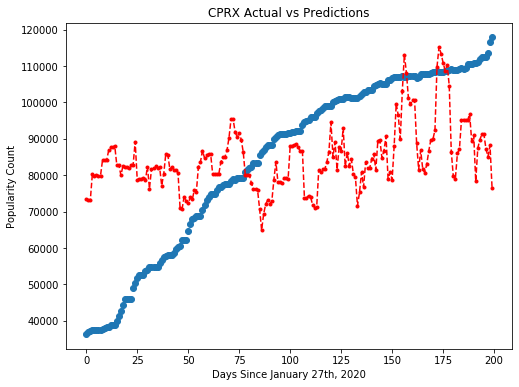

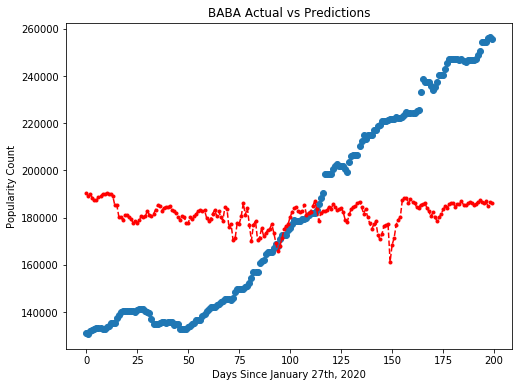

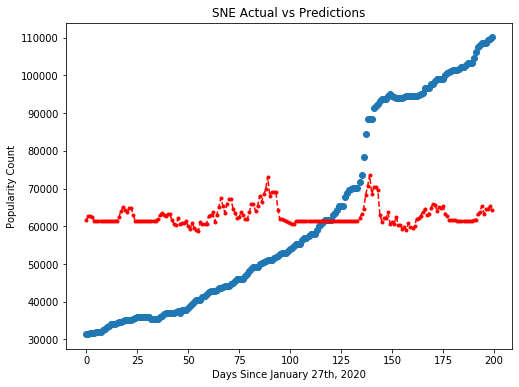

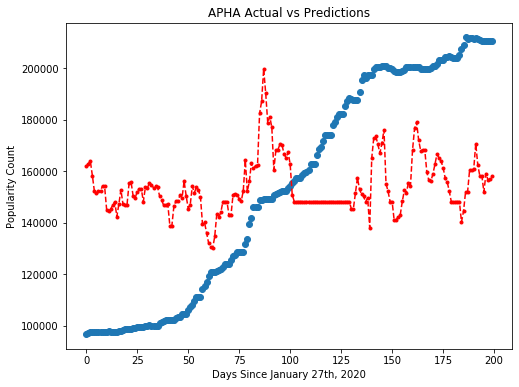

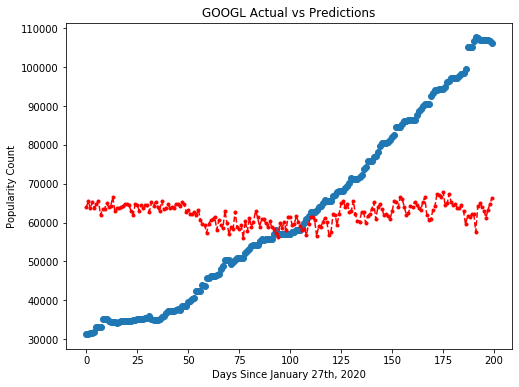

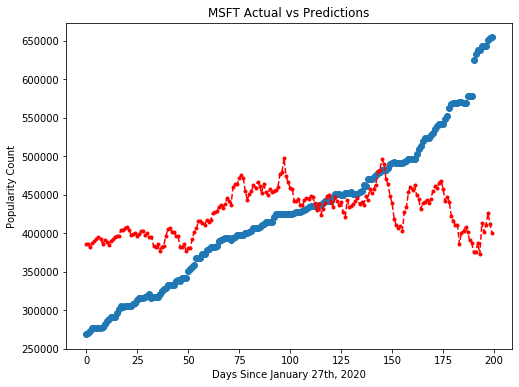

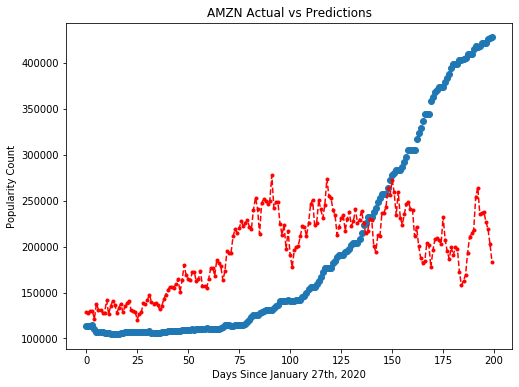

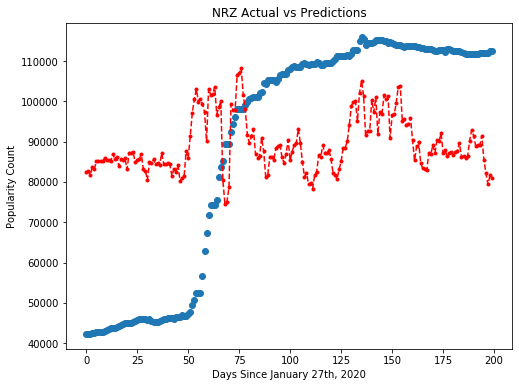

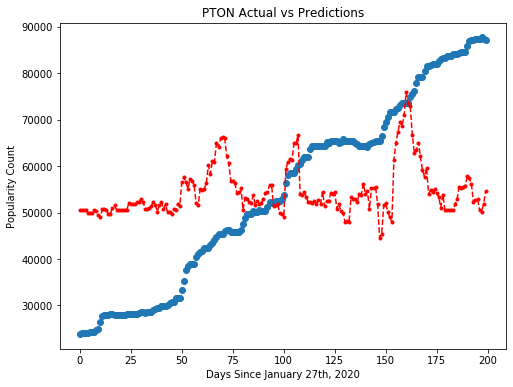

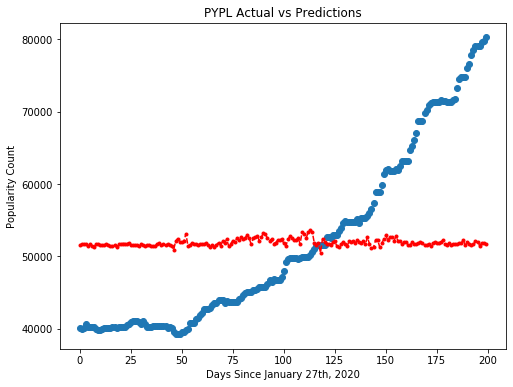

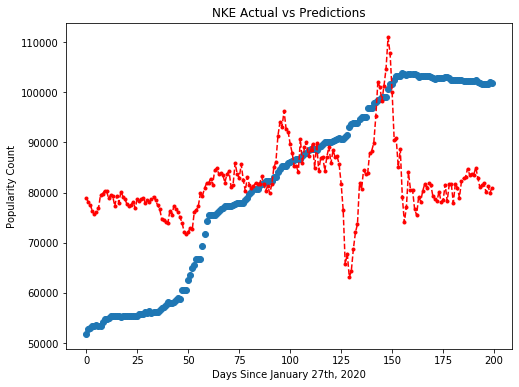

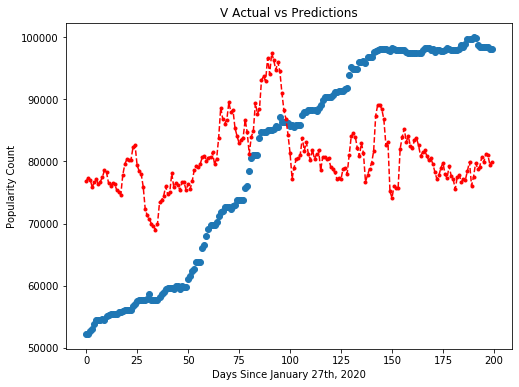

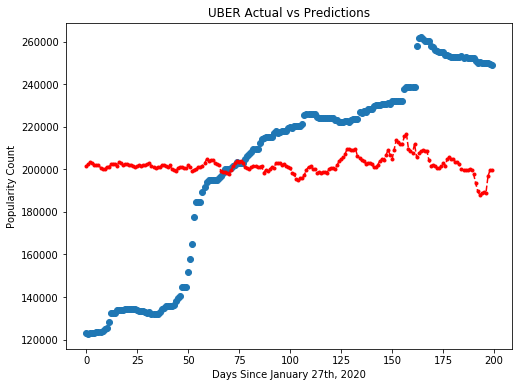

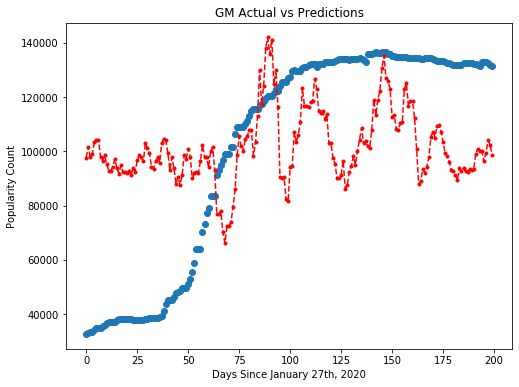

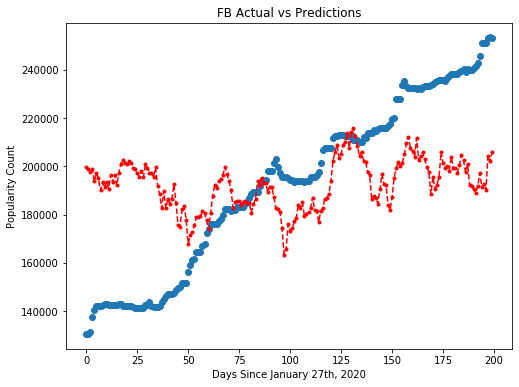

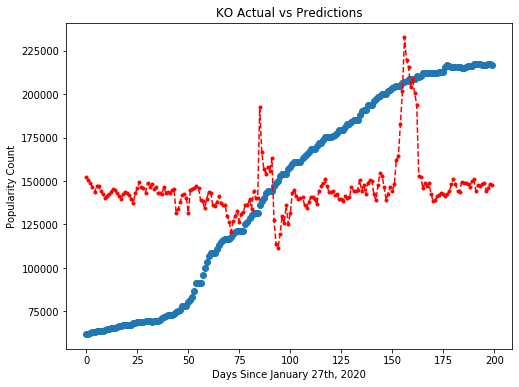

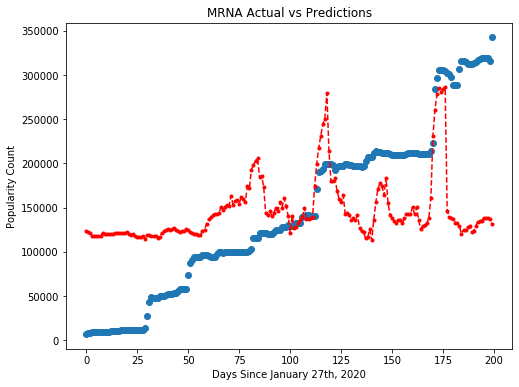

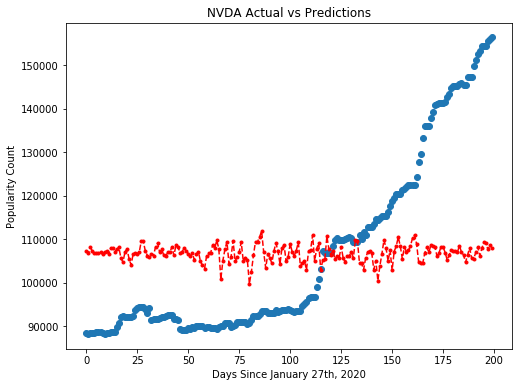

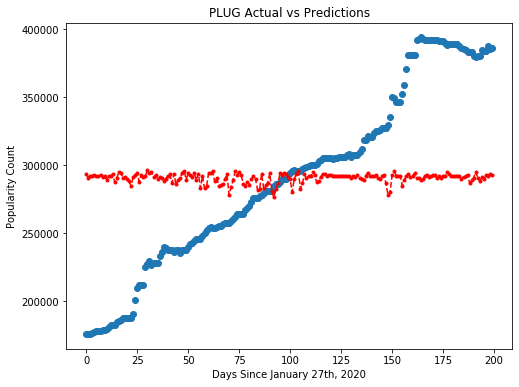

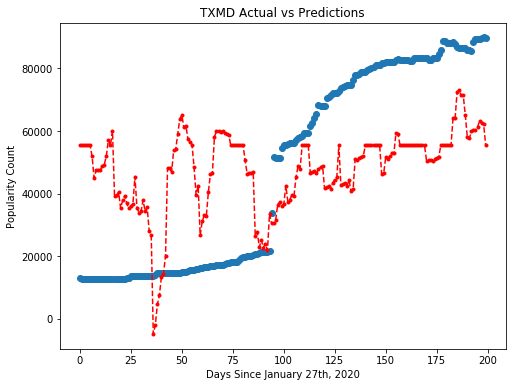

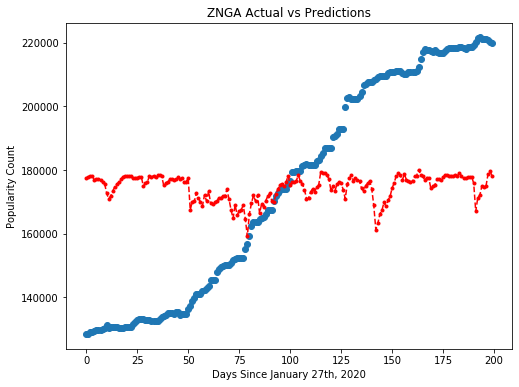

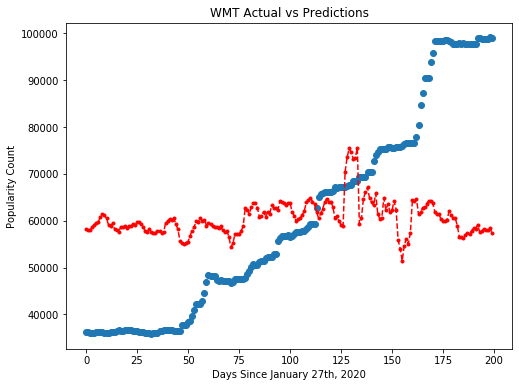

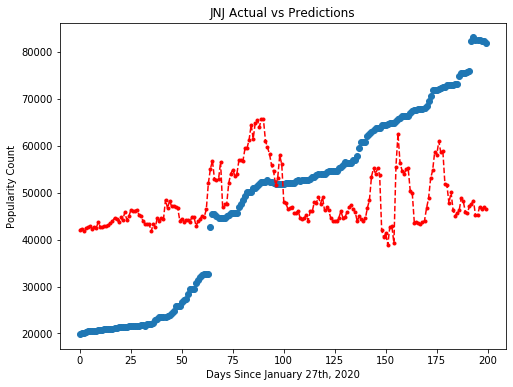

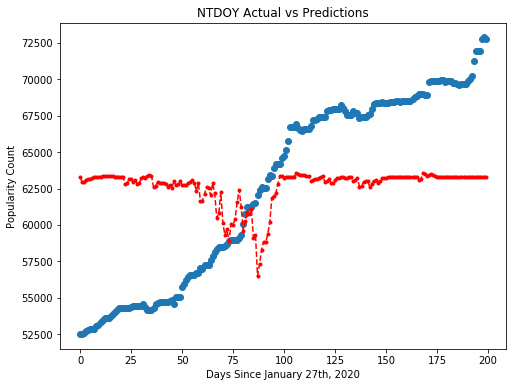

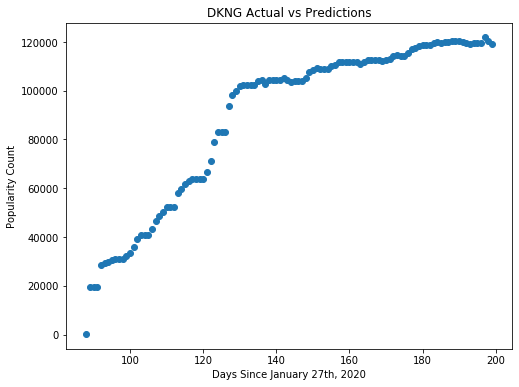

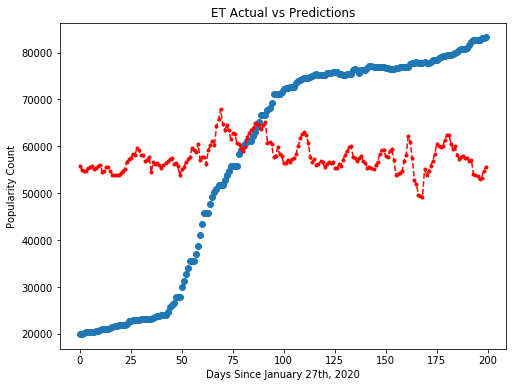

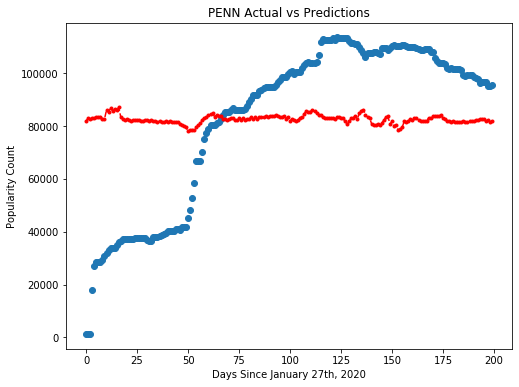

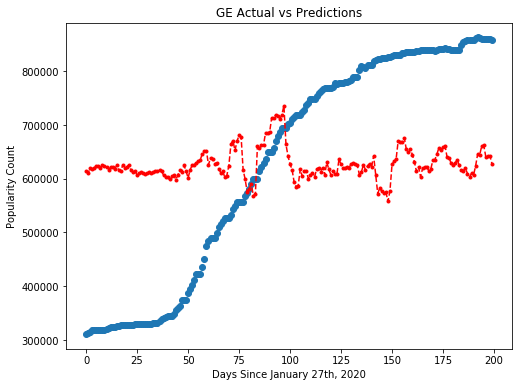

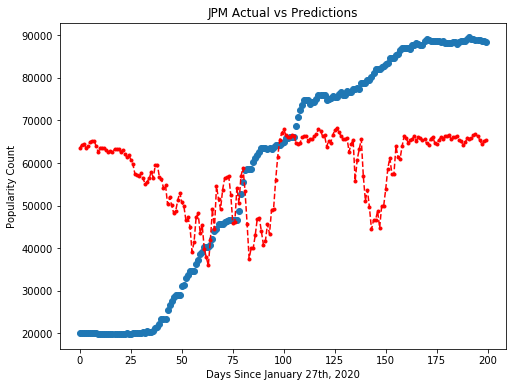

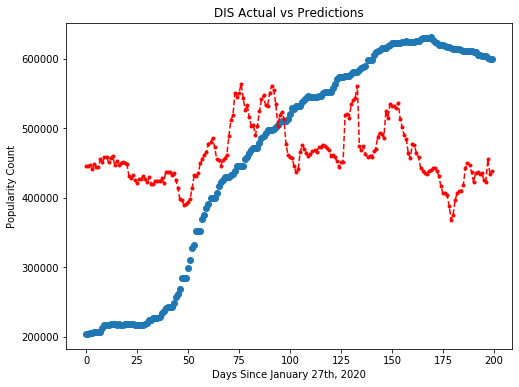

In [70]:
# Fitting our OLS model and graphing/saving graph to data folder
# Setting our window for using our mean scores as predictors
window = 7

# Iterating through our companies
for company in companies:
    # Creating our x and y arrays/lists
    y = [robinhood_data[robinhood_data['date'] == date][company].values for date in dates[6 +  window - 1:-2]]
    x = []
    
    # adding our 7 predictors into the x array
    for i in range(len(dates[6:-2]) - window + 1):
        x.append([])
        # Iterating through our window and adding the mean
        for date in dates[6:-2][i:i + window]:
            s = news_data[(news_data['date'] == date) & (news_data['stock'] == company)]['compound']
            if len(s):
                x[-1].append(s.sum())
            else:
                x[-1].append(0)
    
    # Fitting our model
    x = sm.add_constant(x) # adding a constant
    model = sm.OLS(y, x) # fitting OLS
    results = model.fit()
    print(results.summary()) # Printing a summary of our model
    
    # Plotting our predicted popularity vs actual popularity over time
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(list(range(len(dates[6 +  window - 1:-2]))), y, 'o', label="data")
    ax.plot(list(range(len(dates[6 +  window - 1:-2]))), results.fittedvalues, 'r--.', label="OLS")
    plt.xlabel('Days Since January 27th, 2020')
    plt.ylabel('Popularity Count')
    plt.title(company + ' Actual vs Predictions')
    plt.savefig('./graphs/' + company + '.png')

CPRX Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2323.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          3.07e-163
Time:                        01:37:31   Log-Likelihood:                -1912.1
No. Observations:                 200   AIC:                             3834.
Df Residuals:                     195   BIC:                             3851.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.991e+04   3399.485     -5

GOOGL Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1698.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          2.77e-150
Time:                        01:37:34   Log-Likelihood:                -1936.4
No. Observations:                 200   AIC:                             3883.
Df Residuals:                     195   BIC:                             3899.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3955.1333   3838.629      

PTON Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     8712.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          1.48e-218
Time:                        01:37:36   Log-Likelihood:                -1745.8
No. Observations:                 200   AIC:                             3502.
Df Residuals:                     195   BIC:                             3518.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.654e+04   1479.563    -11

UBER Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1834.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          1.83e-153
Time:                        01:37:38   Log-Likelihood:                -2060.0
No. Observations:                 200   AIC:                             4130.
Df Residuals:                     195   BIC:                             4146.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.371e+04   7119.762     -1

MRNA Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1040.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          2.78e-130
Time:                        01:37:41   Log-Likelihood:                -2265.4
No. Observations:                 200   AIC:                             4541.
Df Residuals:                     195   BIC:                             4557.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.469e+05   1.99e+04     -7

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ZNGA Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     4717.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          8.84e-193
Time:                        01:37:43   Log-Likelihood:                -1912.4
No. Observations:                 200   AIC:                             3835.
Df Residuals:                     195   BIC:                             3851.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.09e+04   3403.273     26

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


WMT Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1734.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          3.73e-151
Time:                        01:37:44   Log-Likelihood:                -1918.5
No. Observations:                 200   AIC:                             3847.
Df Residuals:                     195   BIC:                             3863.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6071.5197   3509.218      1.

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JNJ Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2392.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          1.87e-164
Time:                        01:37:44   Log-Likelihood:                -1864.3
No. Observations:                 200   AIC:                             3739.
Df Residuals:                     195   BIC:                             3755.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8713.5731   2676.350     -3.

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


NTDOY Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1596.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          9.61e-148
Time:                        01:37:45   Log-Likelihood:                -1685.1
No. Observations:                 200   AIC:                             3380.
Df Residuals:                     195   BIC:                             3397.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.105e+04   1092.677     3

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


DKNG Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                nan
Time:                        01:37:45   Log-Likelihood:                    nan
No. Observations:                 200   AIC:                               nan
Df Residuals:                     195   BIC:                               nan
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan       

/home/sharne/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/sharne/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/sharne/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much me

ET Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1131.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          1.12e-133
Time:                        01:37:46   Log-Likelihood:                -1975.9
No. Observations:                 200   AIC:                             3962.
Df Residuals:                     195   BIC:                             3978.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.105e+04   4676.731     -6.6

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


PENN Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     529.4
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          1.72e-103
Time:                        01:37:46   Log-Likelihood:                -2102.9
No. Observations:                 200   AIC:                             4216.
Df Residuals:                     195   BIC:                             4232.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.097e+04   8822.754     -8

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


GE Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2319.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          3.70e-163
Time:                        01:37:47   Log-Likelihood:                -2343.4
No. Observations:                 200   AIC:                             4697.
Df Residuals:                     195   BIC:                             4713.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.891e+04   2.94e+04     -2.3

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


JPM Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     3286.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          1.16e-177
Time:                        01:37:47   Log-Likelihood:                -1896.1
No. Observations:                 200   AIC:                             3802.
Df Residuals:                     195   BIC:                             3819.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.742e+04   3136.893     -8.

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


DIS Summary
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2527.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):          9.98e-167
Time:                        01:37:48   Log-Likelihood:                -2277.7
No. Observations:                 200   AIC:                             4565.
Df Residuals:                     195   BIC:                             4582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.55e+05   2.11e+04     -7.

/home/sharne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


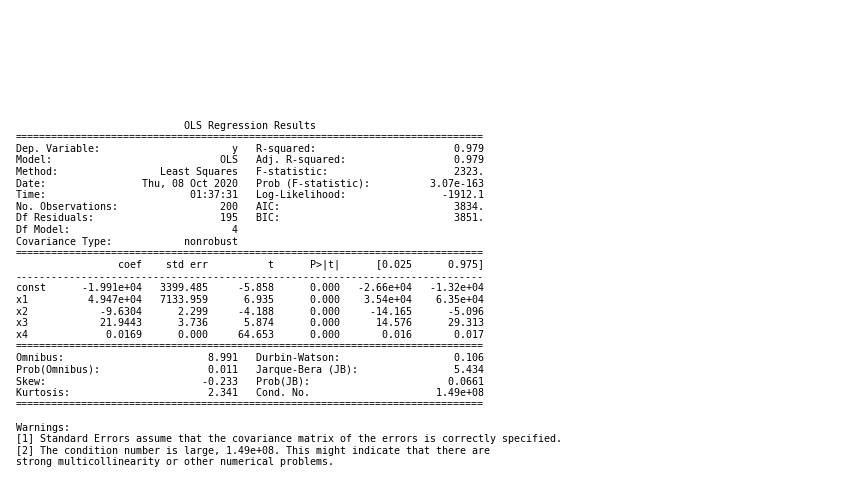

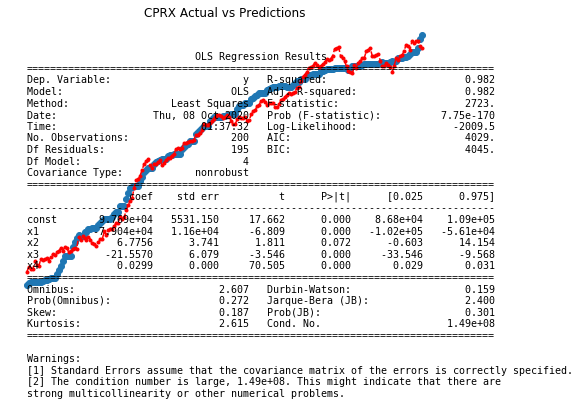

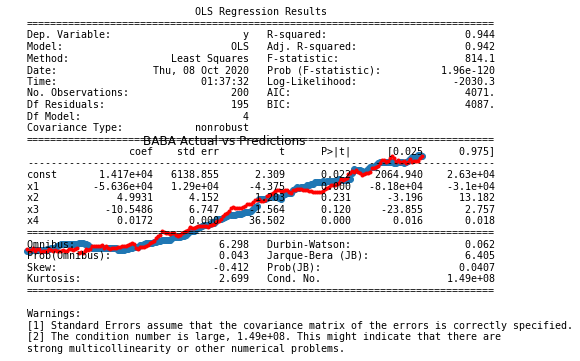

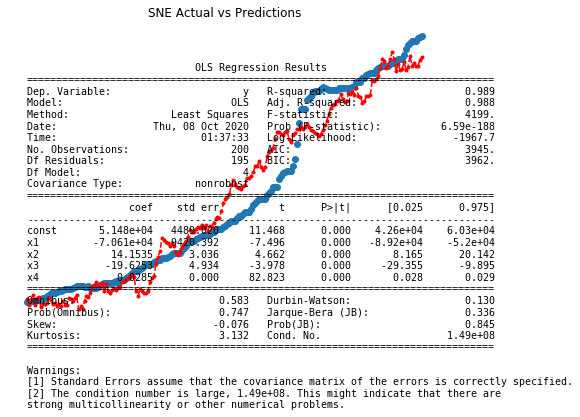

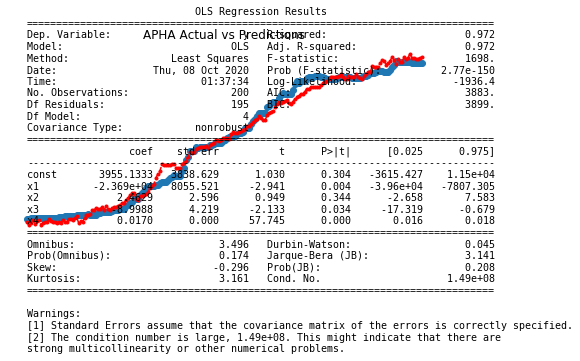

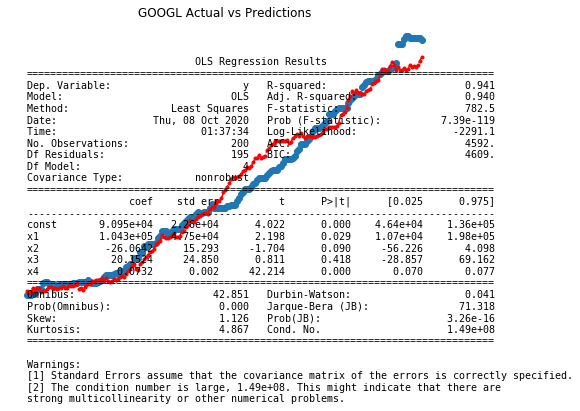

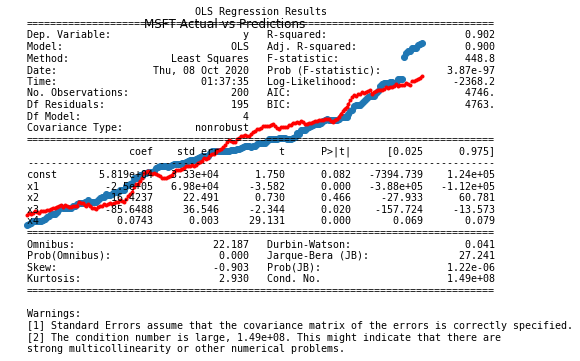

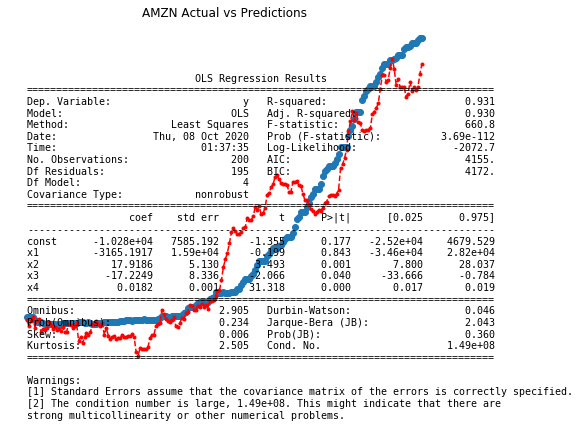

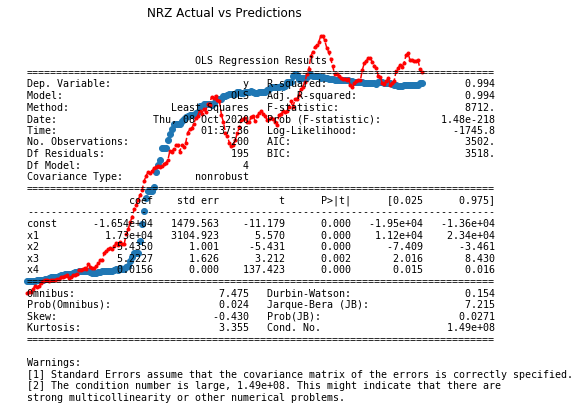

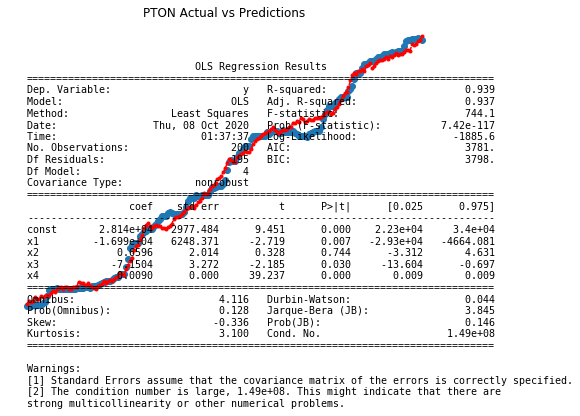

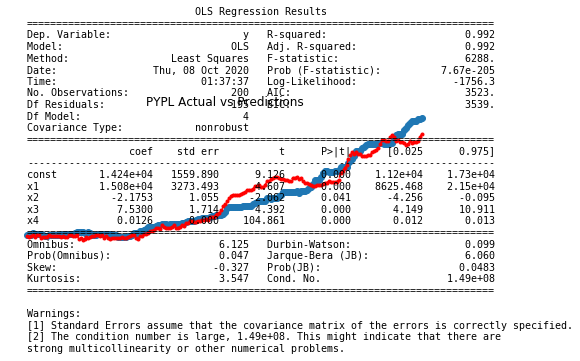

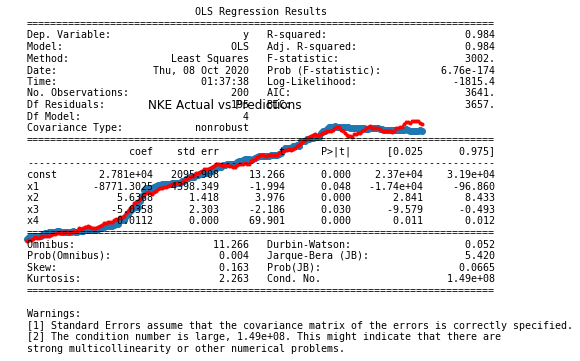

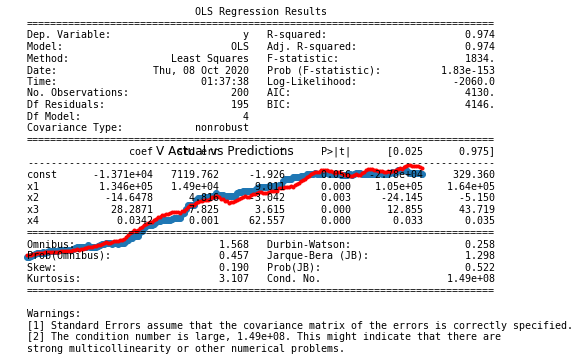

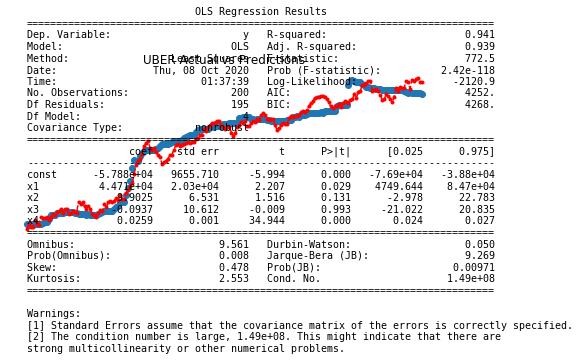

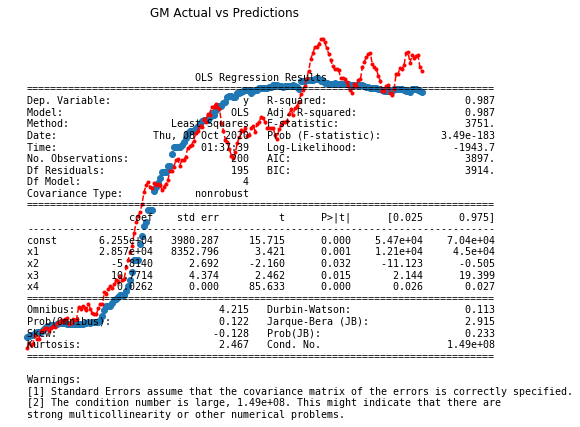

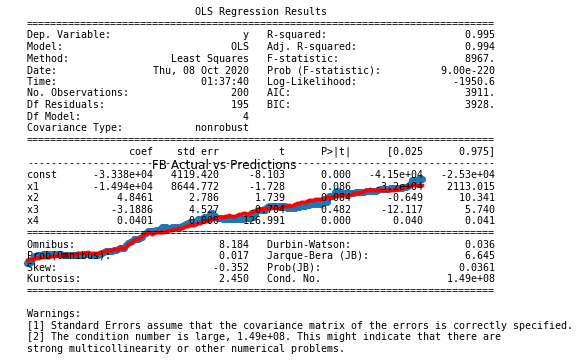

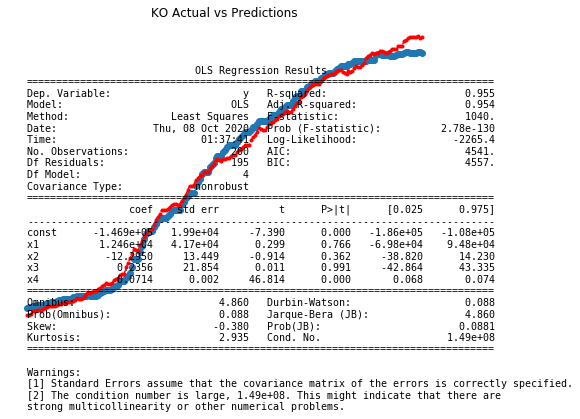

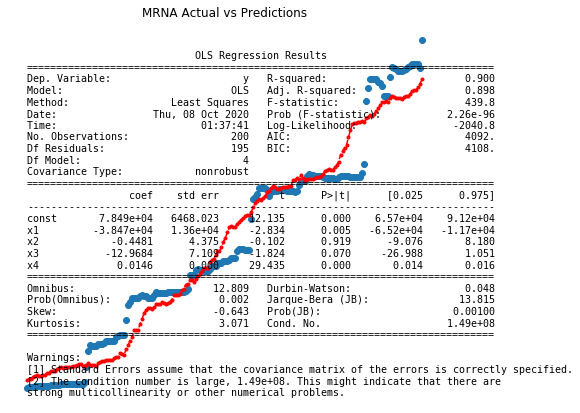

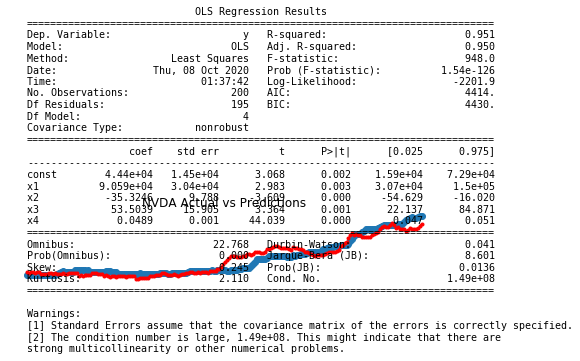

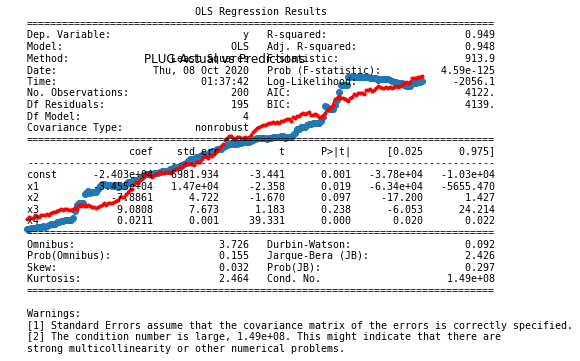

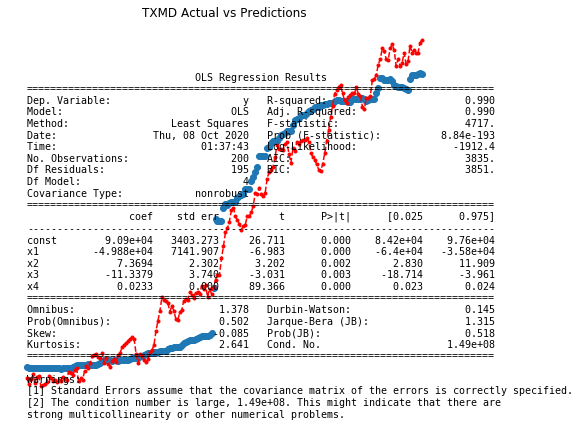

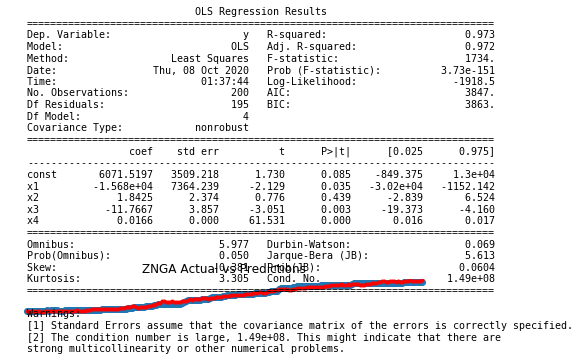

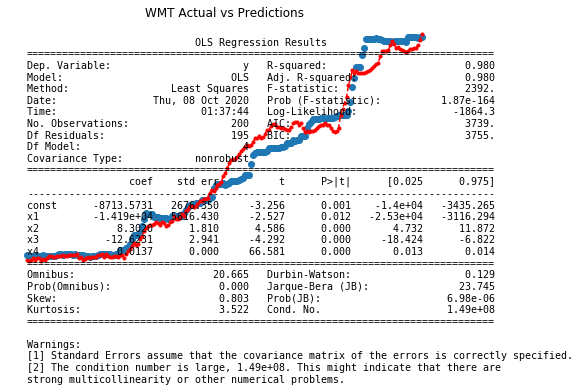

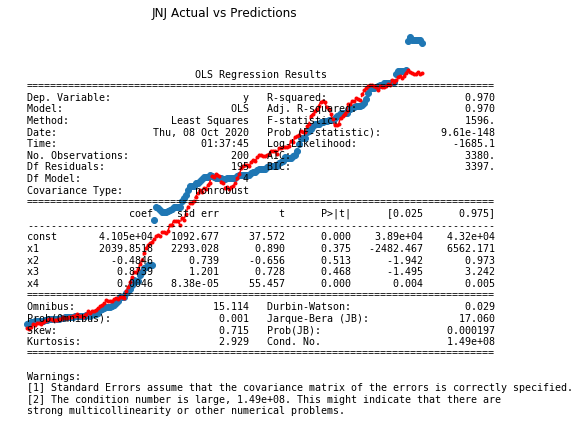

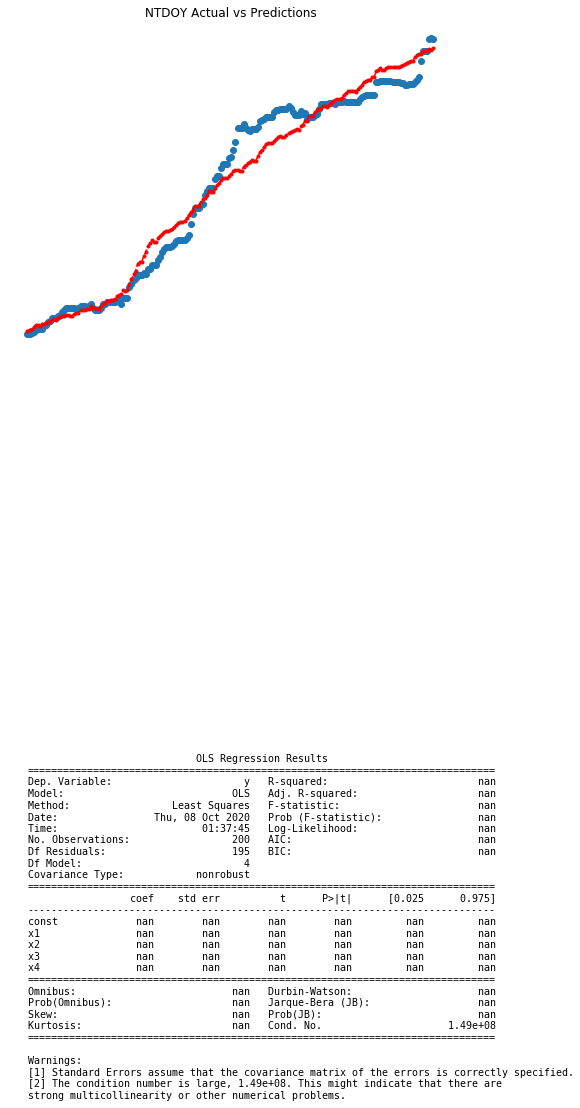

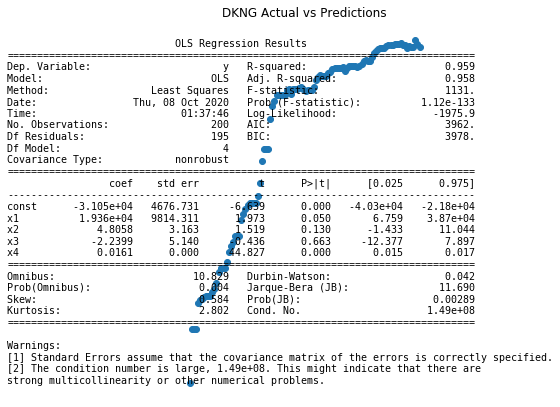

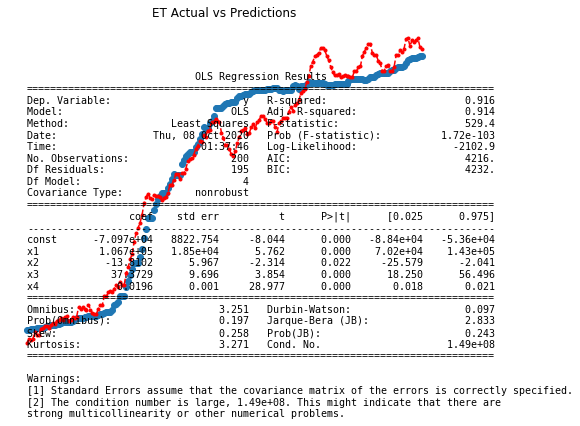

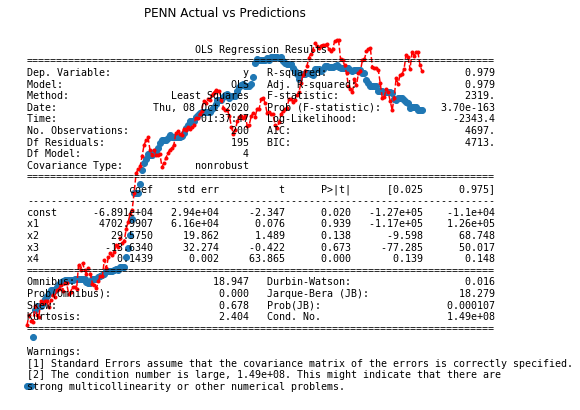

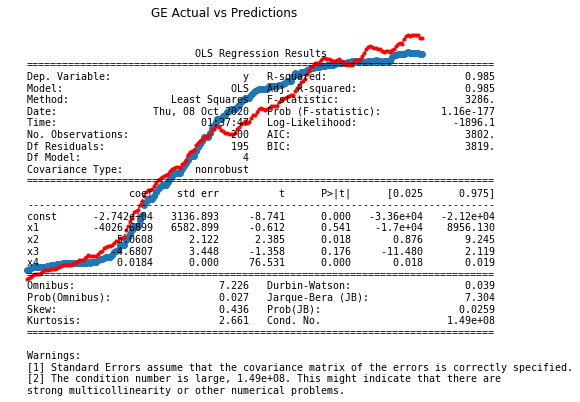

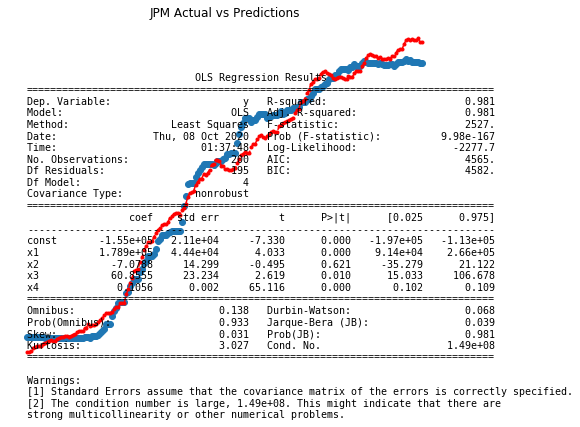

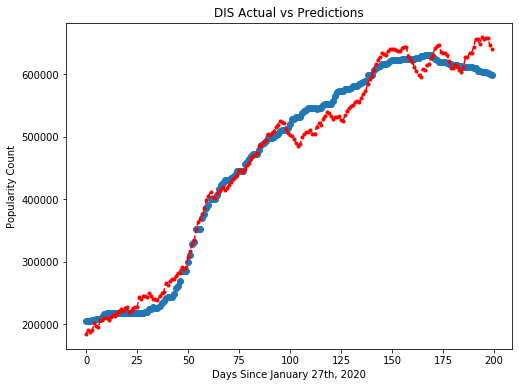

In [89]:
# Fitting our OLS model and graphing/saving graph to data folder
# Setting our window for using our mean scores as predictors
window = 7

# Iterating through our companies
for company in companies:
    # Creating our x and y arrays/lists
    y = [robinhood_data[robinhood_data['date'] == date][company].values for date in dates[6 +  window - 1:-2]]
    x = []
    
    # adding our 7 predictors into the x array
    for date in dates[6 +  window - 1:-2]:
        # Iterating through our window and adding the mean
        s = smoothed_scores_df[(smoothed_scores_df['stock'] == company) & (smoothed_scores_df['date'] == date)]
        x.append(s[['score', 'pos_count', 'neg_count', 'all_counts']].values[0])
    
    # Fitting our model
    x = sm.add_constant(x) # adding a constant
    model = sm.OLS(y, x) # fitting OLS
    results = model.fit()
    print(company + ' Summary')
    print(results.summary()) # Printing a summary of our model
        
    plt.rc('figure', figsize=(12, 7))
    #plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
    plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('./graphs/results_' + company + '.png')
    
    # Plotting our predicted popularity vs actual popularity over time
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(list(range(len(dates[6 +  window - 1:-2]))), y, 'o', label="data")
    ax.plot(list(range(len(dates[6 +  window - 1:-2]))), results.fittedvalues, 'r--.', label="OLS")
    plt.xlabel('Days Since January 27th, 2020')
    plt.ylabel('Popularity Count')
    plt.title(company + ' Actual vs Predictions')
    plt.savefig('./graphs/' + company + '.png')

In [86]:
type(results.summary())

statsmodels.iolib.summary.Summary

Text(0.5, 1.0, 'Distribution of Sentiment Scores From Financial Headlines')

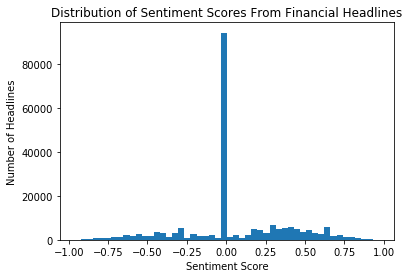

In [51]:
# Plotting the distribution of sentiment scores
plt.hist(news_data['compound'].values, bins = 50)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Headlines')
plt.title('Distribution of Sentiment Scores From Financial Headlines')

Text(0.5, 1.0, 'Distribution of Sentiment Scores From Financial Headlines')

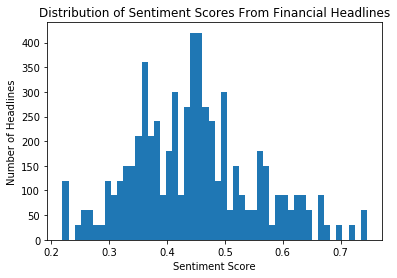

In [13]:
# Plotting the distribution of sentiment scores
plt.hist(smoothed_scores_df['score'].values, bins = 50)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Headlines')
plt.title('Distribution of Sentiment Scores From Financial Headlines')